In [1]:
from models import fc
from datasets import mnist
from logger import Logger
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [4]:
batch_size = 256
input_dim = 784
classes = 10
learning_rate = 0.001
reg = 0.01

epochs = 5

In [5]:
def compute_accuracy(model, dataloader):
    
    correct, total = 0.0, 0.0
    
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        outputs = model(Variable(inputs))
        _, pred = torch.max(outputs.data, 1)
        
        correct += torch.eq(pred, labels).sum()
        total += labels.size(0)
    
    return correct/float(total)

In [6]:
train_data, valid_data, test_data = mnist.MNIST.load_data(batch_size)
model = fc.FullyConnected(input_dim, classes)

loss_criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=reg)

In [7]:
losses = []
valid_accs = []
train_accs = []

for epoch in xrange(epochs):
    
    for i, data in enumerate(train_data):
        inputs, labels = data
        inputs = Variable(inputs)
        labels_var = Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = loss_criteria(outputs, labels_var)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data[0])
        print "\t Iteration %d : Loss: %f" % (i, loss.data[0])
    
    train_acc = compute_accuracy(model, train_data)
    valid_acc = compute_accuracy(model, valid_data)
    
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    print "Epoch %d complete. Training acc: %f. Validation accuracy: %f" % (epoch, train_acc, valid_acc)

	 Iteration 0 : Loss: 2.313469
	 Iteration 1 : Loss: 2.152128
	 Iteration 2 : Loss: 2.059699
	 Iteration 3 : Loss: 1.997759
	 Iteration 4 : Loss: 1.901287
	 Iteration 5 : Loss: 1.863064
	 Iteration 6 : Loss: 1.804654
	 Iteration 7 : Loss: 1.771822
	 Iteration 8 : Loss: 1.707772
	 Iteration 9 : Loss: 1.701192
	 Iteration 10 : Loss: 1.664091
	 Iteration 11 : Loss: 1.641021
	 Iteration 12 : Loss: 1.597239
	 Iteration 13 : Loss: 1.532074
	 Iteration 14 : Loss: 1.513340
	 Iteration 15 : Loss: 1.485102
	 Iteration 16 : Loss: 1.436826
	 Iteration 17 : Loss: 1.460037
	 Iteration 18 : Loss: 1.428600
	 Iteration 19 : Loss: 1.383842
	 Iteration 20 : Loss: 1.388536
	 Iteration 21 : Loss: 1.326075
	 Iteration 22 : Loss: 1.305742
	 Iteration 23 : Loss: 1.317282
	 Iteration 24 : Loss: 1.261076
	 Iteration 25 : Loss: 1.243247
	 Iteration 26 : Loss: 1.213078
	 Iteration 27 : Loss: 1.205946
	 Iteration 28 : Loss: 1.176294
	 Iteration 29 : Loss: 1.164668
	 Iteration 30 : Loss: 1.164613
	 Iteration 31 : L

In [8]:
test_acc = compute_accuracy(model, test_data)
print "Test accuracy: %f" % (test_acc)

Test accuracy: 0.969700


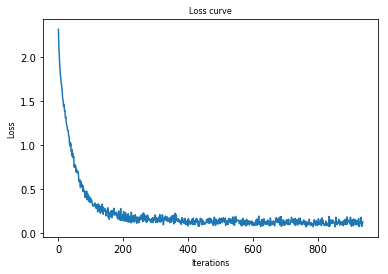

In [9]:
# Plot loss

plt.plot(losses)
plt.xlabel('Iterations', fontsize=8)
plt.ylabel('Loss', fontsize=8)
plt.title('Loss curve', fontsize=8)
plt.savefig('results/1-fc-mnist/loss_curve.png')

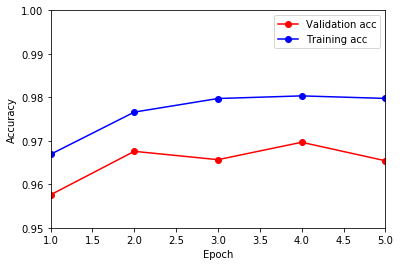

In [10]:
# Plot validation and train accuracy

plt.plot(range(1, epochs+1), valid_accs, 'r-o')
plt.plot(range(1, epochs+1), train_accs, 'b-o')
plt.xlim(1, epochs)
plt.ylim(0.95, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Validation acc', 'Training acc'])
plt.savefig('results/1-fc-mnist/train_val_acc.png')

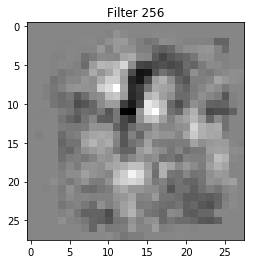

In [11]:
# Visualize FC1 weights

fc1_weight = model.state_dict()['fc1.weight']
fc1_img = fc1_weight.view(-1, 28, 28)
img_size = fc1_img.shape[0]

for i in xrange(img_size):
    filter_img = fc1_img[i-1]
    
    plt.imshow(filter_img.numpy(), cmap='gray')
    plt.title('Filter %d' % (i+1))
    plt.savefig('results/1-fc-mnist/fc1-vis/filter-%d.png' % (i+1))

In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [13]:
# fc4 stores the hidden 64-dimensional encoding of the images. Visualize using t-SNE

fc4_tsne_codes = np.array([])
fc4_pca_codes = np.array([])
img_labels = np.array([])

def capture_fc4_out(model, inputs, outputs):
    
    global fc4_tsne_codes, fc4_pca_codes
    
    outputs = outputs.data.cpu().numpy()
    
    fc4_embedded_tsne = TSNE(n_components=2).fit_transform(outputs)
    fc4_embedded_pca = PCA(n_components=2).fit_transform(outputs)
    
    if fc4_tsne_codes.shape[0] <= 0:
        fc4_tsne_codes = fc4_embedded_tsne
        fc4_pca_codes = fc4_embedded_pca
    else:
        fc4_tsne_codes = np.concatenate((fc4_tsne_codes, fc4_embedded_tsne))
        fc4_pca_codes = np.concatenate((fc4_pca_codes, fc4_embedded_pca))

model.fc4.register_forward_hook(capture_fc4_out)
cnt = 0

for i, data in enumerate(test_data):
    
    inputs, labels = data
    inputs = Variable(inputs)
    
    output = model(inputs)
    
    if img_labels.shape[0] <= 0:
        img_labels = labels.numpy()
    else:
        img_labels = np.append(img_labels, labels.numpy())
    
    cnt += labels.shape[0]
    print "%d processed" % cnt
    print fc4_tsne_codes.shape, fc4_pca_codes.shape, img_labels.shape

256 processed
(256, 2) (256, 2) (256,)
512 processed
(512, 2) (512, 2) (512,)
768 processed
(768, 2) (768, 2) (768,)
1024 processed
(1024, 2) (1024, 2) (1024,)
1280 processed
(1280, 2) (1280, 2) (1280,)
1536 processed
(1536, 2) (1536, 2) (1536,)
1792 processed
(1792, 2) (1792, 2) (1792,)
2048 processed
(2048, 2) (2048, 2) (2048,)
2304 processed
(2304, 2) (2304, 2) (2304,)
2560 processed
(2560, 2) (2560, 2) (2560,)
2816 processed
(2816, 2) (2816, 2) (2816,)
3072 processed
(3072, 2) (3072, 2) (3072,)
3328 processed
(3328, 2) (3328, 2) (3328,)
3584 processed
(3584, 2) (3584, 2) (3584,)
3840 processed
(3840, 2) (3840, 2) (3840,)
4096 processed
(4096, 2) (4096, 2) (4096,)
4352 processed
(4352, 2) (4352, 2) (4352,)
4608 processed
(4608, 2) (4608, 2) (4608,)
4864 processed
(4864, 2) (4864, 2) (4864,)
5120 processed
(5120, 2) (5120, 2) (5120,)
5376 processed
(5376, 2) (5376, 2) (5376,)
5632 processed
(5632, 2) (5632, 2) (5632,)
5888 processed
(5888, 2) (5888, 2) (5888,)
6144 processed
(6144, 2

In [14]:
colors = plt.get_cmap('Vega10').colors
labels_colors_vect = [colors[label] for label in img_labels]

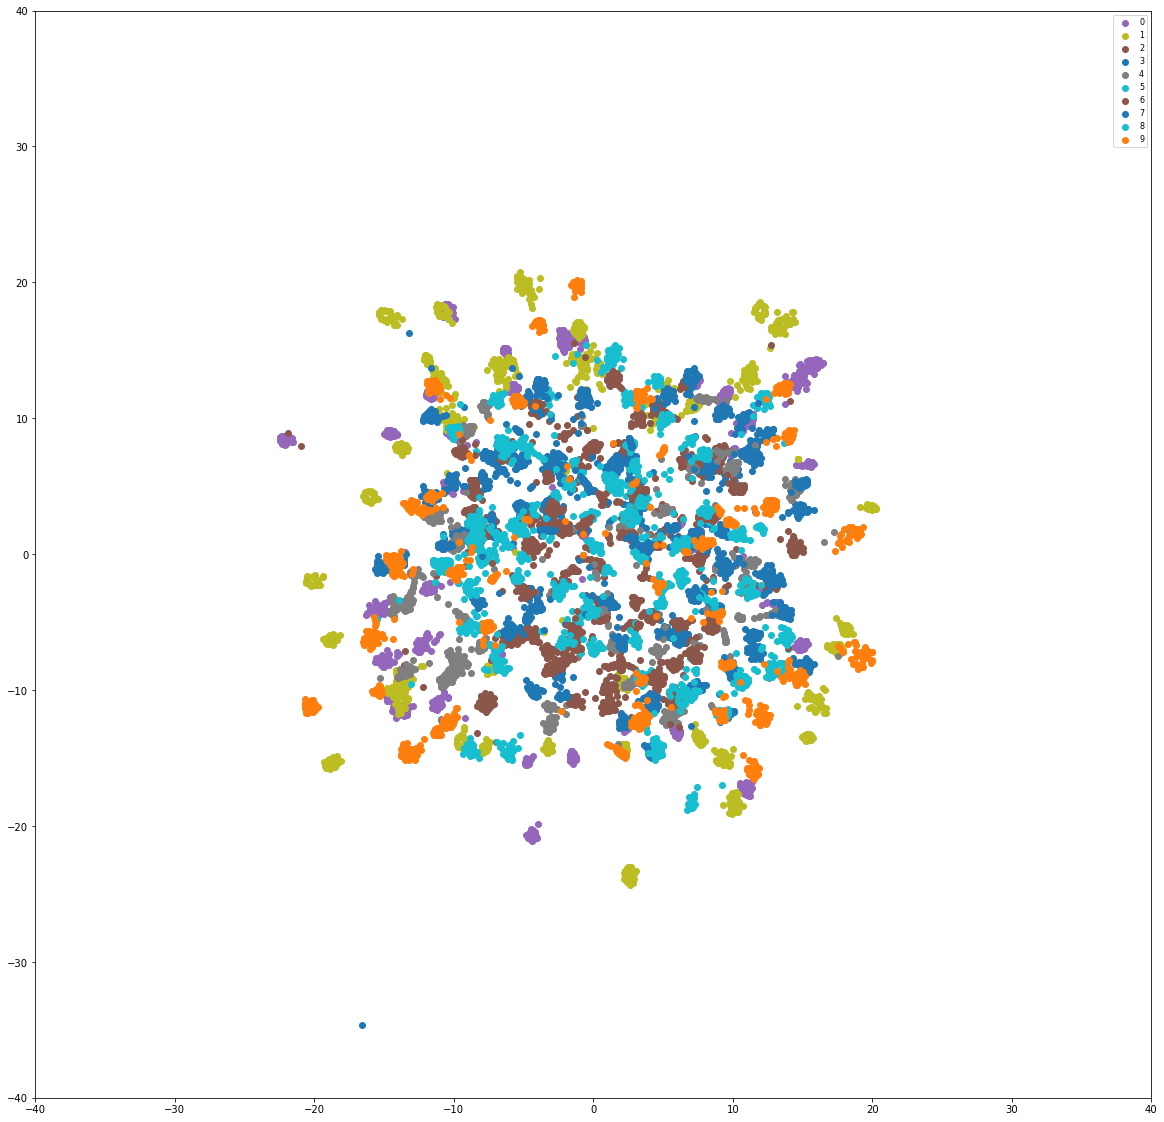

In [21]:
plt.figure(figsize=(20, 20))
scatter_i = []

for i in xrange(10):
    idxs = (img_labels == i)
    scatter_i.append(
        plt.scatter(fc4_tsne_codes[idxs,0], fc4_tsne_codes[idxs, 1], color=labels_colors_vect[i])
    )
    
plt.legend(scatter_i, range(10), fontsize=8)
plt.xlim((-40, 40))
plt.ylim((-40, 40))
plt.show()

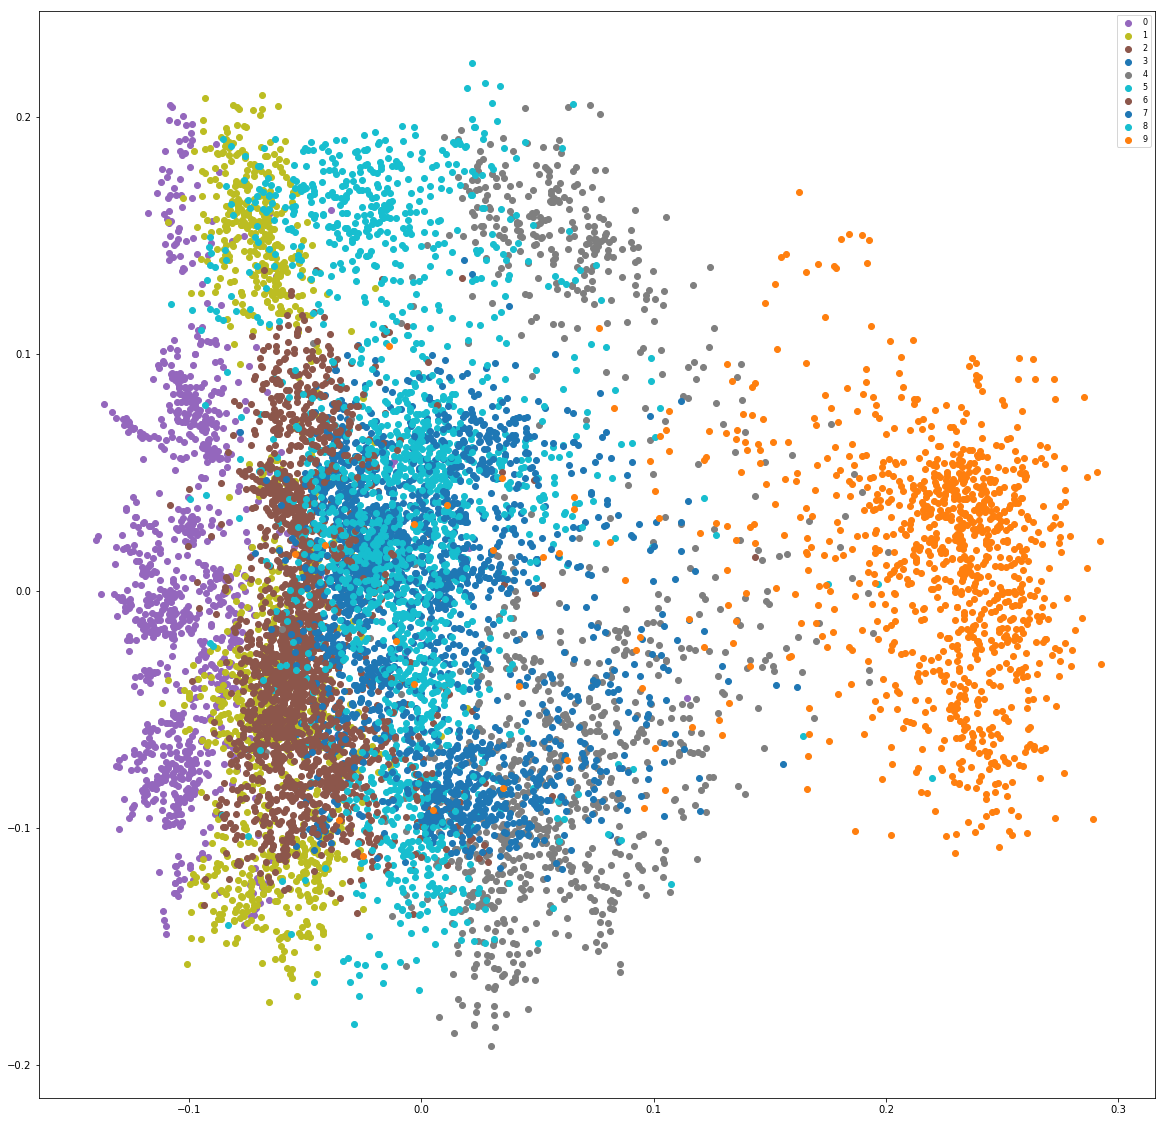

In [16]:
plt.figure(figsize=(20, 20))
scatter_i = []

for i in xrange(10):
    idxs = (img_labels == i)
    scatter_i.append(
        plt.scatter(fc4_pca_codes[idxs,0], fc4_pca_codes[idxs, 1], color=labels_colors_vect[i])
    )
    
plt.legend(scatter_i, range(10), fontsize=8)
plt.show()